In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import mglearn 
from IPython.display import display
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.datasets import load_files

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%matplotlib 
%matplotlib inline
%run jasmine.py

Using matplotlib backend: MacOSX


In [2]:
#Loading experiment title/description from data folder
dataset=load_files('data')

In [3]:
#Extracting Experiment IDs from file names data//no//exp_ID --> exp_ID
print type(dataset.filenames)

exp_IDs = []

for fn in dataset.filenames: 
    if "yes" not in fn:
        id=fn.replace('data\\no\\','')
        
    else: 
        id=fn.replace('data\\yes\\','')
       
    exp_IDs.append(id)
    
#alldocs=zip(dataset.target,dataset.filenames, dataset.data)


<type 'numpy.ndarray'>


In [4]:
#splitting 'yes'/'no' files ramdomly into training and test set

file_names_train, file_names_test, docs_train, docs_test, y_train, y_test = \
     train_test_split(exp_IDs, dataset.data, dataset.target,
                      test_size=0.25, train_size=0.75, random_state=10)

print "Number of Experiments: %d" %(len(dataset.filenames))
print
print "Number of Training Experiments: %d" % (len(docs_train))
print "Yes count: %d" % (y_train.tolist()).count(1)
print "No count: %d" % (y_train.tolist()).count(0)
print
print "Number of Test Experiments: %d" % (len(docs_test))
print "Yes count: %d" % (y_test.tolist()).count(1)
print "No count: %d" % (y_test.tolist()).count(0)

Number of Experiments: 2379

Number of Training Experiments: 1784
Yes count: 352
No count: 1432

Number of Test Experiments: 595
Yes count: 134
No count: 461


In [5]:
# Running Gridsearch on various parameters to find best parameter set

clf=Pipeline([('vect',    TfidfVectorizer(strip_accents='ascii',
                                      token_pattern=u'(?u)\\b([a-z_]\w+)\\b',
                                      stop_words="english")),
              ('stdsclr', StandardScaler(copy=True, with_mean=False, with_std=True)),
              ('sgd',     SGDClassifier(verbose=0, eta0=1, class_weight='balanced')),
])
parameters=[{ 'vect__ngram_range':[(1,1),(1,2),(1,3)],
             'vect__min_df':[2],
             'vect__max_df':[.98],
             'sgd__eta0':[.0001, .001, .01],
             'sgd__alpha':[.0001,.001,.01, .1],
             'sgd__loss':[  'hinge','log'],
             'sgd__penalty':['l2', 'l1'],
             #'sgd__loss':[ 'hinge', 'log', 'modified_huber'],
             #'sgd__penalty':['l2','l1','elasticnet'],
             'sgd__n_iter':[5],
             'sgd__learning_rate':['constant','invscaling'],     
        }]
beta=4
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters, scoring=f_scorer, n_jobs=-1, verbose=1)
gs_clf=gs_clf.fit(docs_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.7min finished


In [6]:
# Printing best parameter set
print ("Best Parameters:  SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r" % (param_name, gs_clf.best_params_[param_name]))

Best Parameters:  SGD Classifier with Tfidf Vectorizer: 

sgd__alpha:0.1
sgd__eta0:0.001
sgd__learning_rate:'constant'
sgd__loss:'hinge'
sgd__n_iter:5
sgd__penalty:'l1'
vect__max_df:0.98
vect__min_df:2
vect__ngram_range:(1, 3)


In [7]:
# Printing feature summary
vectorizer=gs_clf.best_estimator_.named_steps["vect"]
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d" % len(feature_names))
print ("First ten features:" )
print (feature_names[0:10])
print
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features:" )
print (feature_names[len(feature_names)/2: middle_ten])
print
print ("Last ten features:")
print (feature_names[-10:])


Number of Features: 18859
First ten features:
[u'a2' u'a_x0080__x0093_' u'a_x0080__x0093_ mice' u'a_x0084_s'
 u'a_x0088__x0092_' u'a_x0088__x0092_ mice' u'a_x0088__x0092_ mice bwa'
 u'a_x0088__x0092_ retina' u'a_x0088__x0092_ retina fold' u'a_x0089_1']

Middle ten features:
[u'ko cell' u'ko cells' u'ko control' u'ko embryos' u'ko es' u'ko es cells'
 u'ko il6' u'ko il6 ko' u'ko ko' u'ko mdr2']

Last ten features:
[u'zooepidemicus' u'zooepidemicus colony' u'zooepidemicus colony forming'
 u'zooepidemicus strongly' u'zooepidemicus strongly suggest' u'zscan4'
 u'zt20' u'zt6' u'zt6 zt20' u'zygotic']


In [8]:
# Run Predictions on the test set and training set
trainedCLF=gs_clf.best_estimator_
y_test_predicted  = trainedCLF.predict(docs_test)
y_train_predicted = trainedCLF.predict(docs_train)

In [12]:
# Print classification results
%run jasmine.py
print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)
print falselyReported(y_test, y_test_predicted, file_names_test)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.46      1.00      0.63       134
         no       1.00      0.66      0.80       461

avg / total       0.88      0.74      0.76       595

F 4: 0.923


[[134   0]
 [155 306]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.41      1.00      0.58       352
         no       1.00      0.65      0.79      1432

avg / total       0.88      0.72      0.75      1784

F 4: 0.923
[[352   0]
 [502 930]]
None
total count:  155

Number of False Positves:  155
['data/no/E-BAIR-12', 'data/no/E-GEOD-38001', 'data/no/E-GEOD-769', 'data/no/E-GEOD-77846', 'data/no/E-MTAB-3814', 'data/no/E-GEOD-58998', 'data/no/E-MTAB-1569', 'data/no/E-GEOD-31013', 'data/no/E-GEOD-44651', 'data/no/E-SMDB-24', 'data/no/E-GEOD-2882']

Number of False Negatives:  0
[]
None


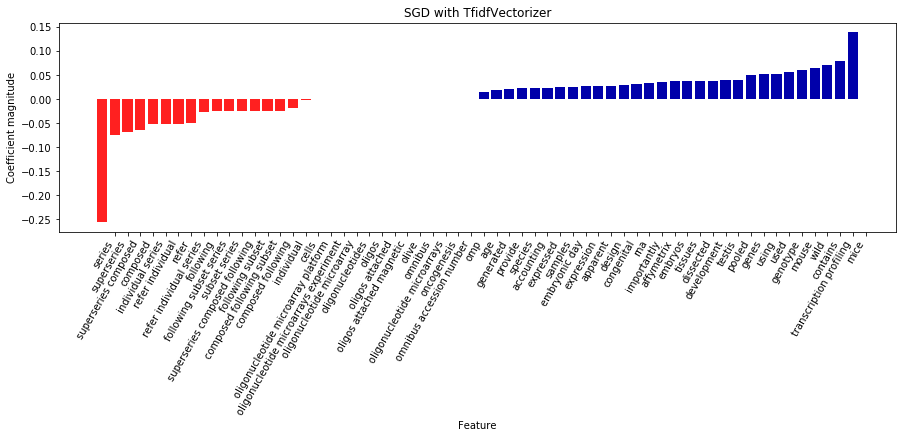

In [10]:
mglearn.tools.visualize_coefficients(
   trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGD with TfidfVectorizer")